# Zadanie: pozostałe metryki

### Importowanie niezbędnych bibliotek

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Przygotowanie, trenowanie, testowanie modelu

In [5]:
# Wczytanie danych
bike_data = pd.read_csv('daily-bike-share.csv')

# Weryfikacja danych
bike_data = bike_data.dropna()  # Usunięcie brakujących danych

# Przygotowanie zmiennych
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']
categorical_features = ['season', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']
target = 'rentals'

# Upewnienie się, że zmienne numeryczne są dodatnie dla PowerTransformer
for col in numeric_features:
    if bike_data[col].min() <= 0:
        bike_data[col] += abs(bike_data[col].min()) + 1

X = bike_data[numeric_features + categorical_features].copy()
y = bike_data[target].copy()

# Podział na zbiory treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Definicja przetwarzania dla zmiennych
numeric_transformer = Pipeline(steps=[
    ('logtransformer', PowerTransformer()),
    ('standardscaler', StandardScaler()),
    ('polynomialfeatures', PolynomialFeatures(degree=2))  # Ograniczenie stopnia wielomianu
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Końcowy preprocesor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Pipeline z modelem ElasticNet
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ElasticNet(max_iter=20000, tol=1e-4))  # Więcej iteracji
])

# Parametry do GridSearch
params = {
    'regressor__alpha': [0.1, 1, 10, 100],  # Zwiększenie wartości alpha
    'regressor__l1_ratio': [0.1, 0.5, 0.9]
}

cv = KFold(n_splits=5, shuffle=False)
final_polynomial_regression_gridsearch = GridSearchCV(
    final_pipeline, params, scoring='neg_mean_squared_error', cv=cv)

# Trenowanie modelu
final_polynomial_regression_gridsearch.fit(X_train, y_train)
best_model = final_polynomial_regression_gridsearch.best_estimator_

# Predykcje
y_test_pred = best_model.predict(X_test)

# Metryki nowego modelu
mae_test_new = mean_absolute_error(y_test, y_test_pred)
rmse_test_new = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test_new = r2_score(y_test, y_test_pred)

# Metryki pierwszego modelu
mae_first = 404
rmse_first = 496
r2_first = 0.64

### Wnioski

In [7]:
# Wyświetlenie wyników
print("\nNajlepsze hiperparametry nowego modelu:")
print(final_polynomial_regression_gridsearch.best_params_)
print(f"\nMetryki nowego modelu na zbiorze testowym:")
print(f"MAE: {mae_test_new}")
print(f"RMSE: {rmse_test_new}")
print(f"R^2: {r2_test_new}")

# Porównanie z pierwszym modelem
print("\nPorównanie metryk z pierwszym modelem:")
print(f"MAE pierwszy: {mae_first}, nowy: {mae_test_new}")
print(f"RMSE pierwszy: {rmse_first}, nowy: {rmse_test_new}")
print(f"R^2 pierwszy: {r2_first}, nowy: {r2_test_new}")

# Wnioski z porównania
print("\nWnioski z porównania:")
if mae_test_new < mae_first:
    print(f"Nowy model zmniejszył MAE o {mae_first - mae_test_new:.2f}, co wskazuje na lepsze dopasowanie.")
else:
    print(f"Nowy model zwiększył MAE o {mae_test_new - mae_first:.2f}, co może wskazywać na problem z dopasowaniem.")

if rmse_test_new < rmse_first:
    print(f"Nowy model zmniejszył RMSE o {rmse_first - rmse_test_new:.2f}, co oznacza mniejsze duże błędy predykcji.")
else:
    print(f"Nowy model zwiększył RMSE o {rmse_test_new - rmse_first:.2f}, co sugeruje większe błędy predykcji.")

if r2_test_new > r2_first:
    print(f"Nowy model poprawił R^2 o {r2_test_new - r2_first:.2f}, co oznacza lepsze wyjaśnienie zmienności.")
else:
    print(f"Nowy model pogorszył R^2 o {r2_first - r2_test_new:.2f}, co wskazuje na gorsze dopasowanie zmienności.")

# Ostateczny wniosek
print("\nOstateczny wniosek:")
if mae_test_new < mae_first and rmse_test_new < rmse_first and r2_test_new > r2_first:
    print("Nowy model jest lepszy od pierwszego modelu na podstawie wszystkich metryk.")
else:
    print("Nowy model nie jest jednoznacznie lepszy od pierwszego. Warto przeanalizować szczegółowe wyniki.")



Najlepsze hiperparametry nowego modelu:
{'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.5}

Metryki nowego modelu na zbiorze testowym:
MAE: 326.2406896391577
RMSE: 454.3979688745695
R^2: 0.58093848139719

Porównanie metryk z pierwszym modelem:
MAE pierwszy: 404, nowy: 326.2406896391577
RMSE pierwszy: 496, nowy: 454.3979688745695
R^2 pierwszy: 0.64, nowy: 0.58093848139719

Wnioski z porównania:
Nowy model zmniejszył MAE o 77.76, co wskazuje na lepsze dopasowanie.
Nowy model zmniejszył RMSE o 41.60, co oznacza mniejsze duże błędy predykcji.
Nowy model pogorszył R^2 o 0.06, co wskazuje na gorsze dopasowanie zmienności.

Ostateczny wniosek:
Nowy model nie jest jednoznacznie lepszy od pierwszego. Warto przeanalizować szczegółowe wyniki.


### Wizualizacje

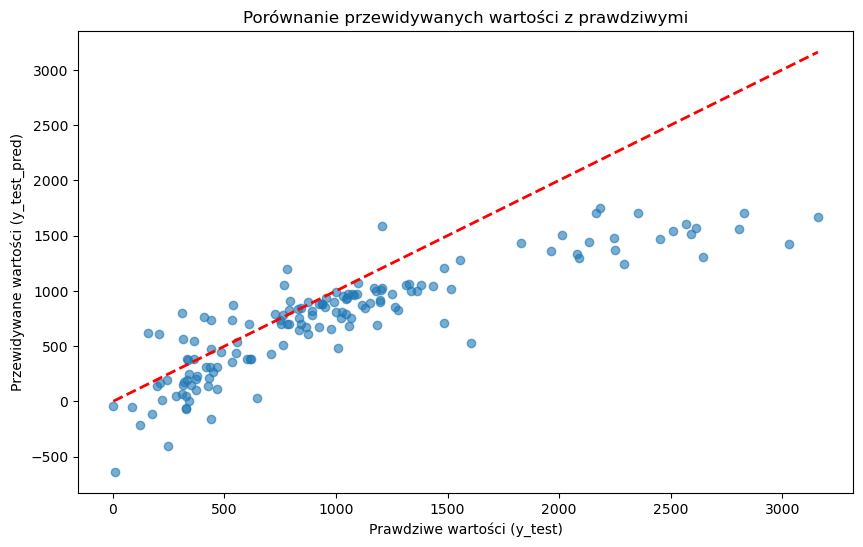

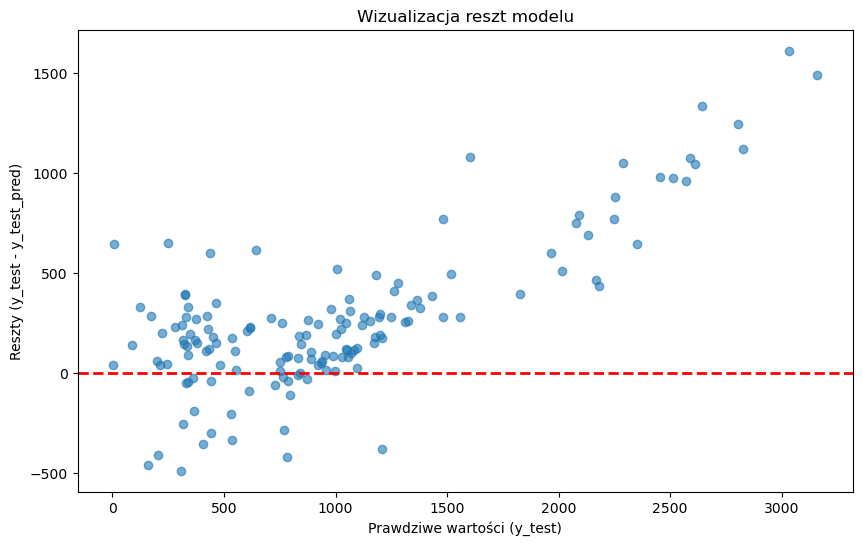

In [9]:
# Wizualizacja wyników predykcji
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Prawdziwe wartości (y_test)')
plt.ylabel('Przewidywane wartości (y_test_pred)')
plt.title('Porównanie przewidywanych wartości z prawdziwymi')
plt.show()

# Wizualizacja reszt
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test, residuals, alpha=0.6)
plt.axhline(0, color='r', linestyle='--', lw=2)
plt.xlabel('Prawdziwe wartości (y_test)')
plt.ylabel('Reszty (y_test - y_test_pred)')
plt.title('Wizualizacja reszt modelu')
plt.show()